<a href="https://colab.research.google.com/github/PravinVedurla/PATE-Analysis-Using-Pysyft-on-MNIST-Digit-Classification/blob/master/MNIST_Digit_Classification_Along_With_PATE_Analysis_Using_Pysyft_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading MNIST Data**

In [0]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])]) #Grey Scale Image
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  #Training data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  #Testing data

In [2]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)
print(mnist_trainset)
print(mnist_testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


**Dataloaders for Teachers**

In [0]:
from torch.utils.data import Subset
num_teachers = 250

teacher_loaders = []  #list of dataloaders

data_size = 240 # mnist_trainset/num_teachers

for i in range(num_teachers):
    
    indices = list(range(i*data_size, (i+1) *data_size)) #creating subsets of 600 data_size
    subset_data = Subset(mnist_trainset, indices)
    
    loader = torch.utils.data.DataLoader(subset_data, batch_size=64, num_workers=2)
    teacher_loaders.append(loader)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Active device:", device)

Active device: cuda:0


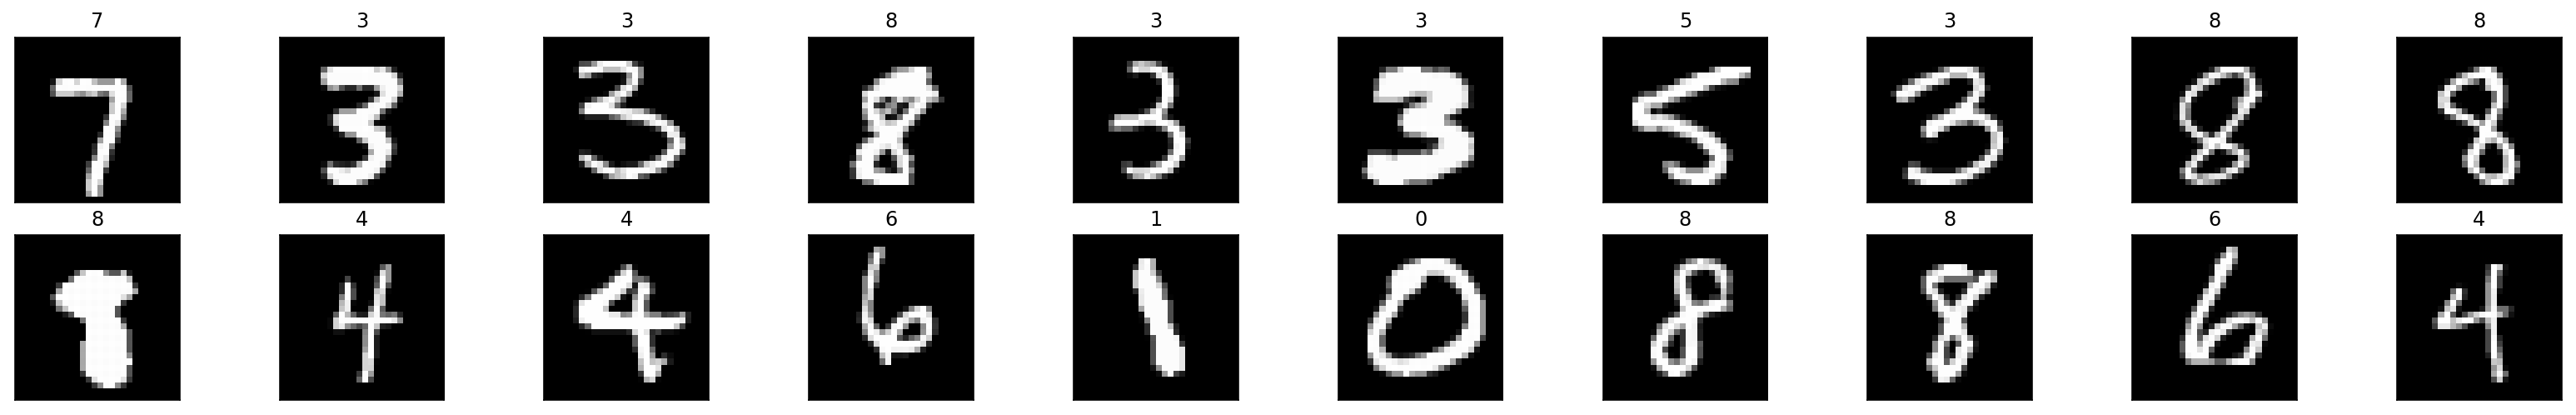

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() #Converts image into a Numpy array

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image.item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

**Create a basic model with the dimensions specified**

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
    
    #Forward Neural Network Architecture model
    
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2) # Dropout module with 0.2 drop probability

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
    """
    
    def __init__(self):
      self.p=0.2
      
      
    def forward(self, x):
      x = nn.Sequential(nn.Linear(784, 256),
                        nn.ReLU(),
                        nn.Dropout(self.p),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Dropout(self.p),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Dropout(self.p),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(dim=1))
      return x
    """

**Training all the teachers at once**

In [8]:
epochs = 10
models = []
for i in range(num_teachers):
    model = Classifier() #Model gets passed from the Classifier class
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    running_loss = 0
    teacher_loss = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in teacher_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    teacher_loss.append(running_loss)
    
    print("Training teacher: {}/{}.. ".format(i+1, num_teachers), "Training Loss: {:.3f}.. ".format(running_loss))
    models.append(model)

Training teacher: 1/250..  Training Loss: 8.759.. 
Training teacher: 2/250..  Training Loss: 8.706.. 
Training teacher: 3/250..  Training Loss: 8.903.. 
Training teacher: 4/250..  Training Loss: 8.736.. 
Training teacher: 5/250..  Training Loss: 8.775.. 
Training teacher: 6/250..  Training Loss: 8.856.. 
Training teacher: 7/250..  Training Loss: 8.767.. 
Training teacher: 8/250..  Training Loss: 8.665.. 
Training teacher: 9/250..  Training Loss: 8.726.. 
Training teacher: 10/250..  Training Loss: 8.774.. 
Training teacher: 11/250..  Training Loss: 8.824.. 
Training teacher: 12/250..  Training Loss: 8.639.. 
Training teacher: 13/250..  Training Loss: 8.865.. 
Training teacher: 14/250..  Training Loss: 8.813.. 
Training teacher: 15/250..  Training Loss: 8.794.. 
Training teacher: 16/250..  Training Loss: 8.787.. 
Training teacher: 17/250..  Training Loss: 8.744.. 
Training teacher: 18/250..  Training Loss: 8.851.. 
Training teacher: 19/250..  Training Loss: 8.770.. 
Training teacher: 20/

In [0]:
#Creating the public dataset
student_traindata = Subset(mnist_testset, list(range(9000))) #90% of Test dat as train data
student_testdata = Subset(mnist_testset, list(range(9000, 10000))) #10% of Test data as test data

In [0]:
#Creating student_loaders
student_trainloader = torch.utils.data.DataLoader(student_traindata, batch_size=64, shuffle=True)
student_testloader = torch.utils.data.DataLoader(student_testdata, batch_size=64, shuffle=True)

In [0]:
def perdict(model, dataloader):
    """
    Perdicts labels for a dataset
    Input: model and dataloader
    """
    outputs = torch.zeros(0, dtype=torch.long).to(device)
    model.to(device)
    model.eval()
    for image, labels in dataloader:
        image, labels = image.to(device), labels.to(device)  
        output = model(image)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
    return outputs

In [0]:
# Creating the Aggregated Teacher and Student labels by combining the predictions of Teacher models
epsilon = 0.25
preds = torch.zeros((len(models),9000), dtype=torch.long) # creating a variable preds that will contain predictions from teacher models
for i, model in enumerate(models):
    results = perdict(model, student_trainloader)
    preds[i] = results 
labels = np.array([]).astype(int) 
for image_preds in np.transpose(preds):    #iterates through preds
    label_counts = np.bincount(image_preds, minlength = 10)  #bincount of 250 preds per set - counts the number of occurances of a digit(predicted) per prediction set. Minlenght = 10 for ten available class labels. 
    beta = 1/ epsilon
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1) #Adds laplasian noise to the label counts (Global DF)
    new_label = np.argmax(label_counts) #argmax returns the largest number.
    labels = np.append(labels, new_label)  # storing all the predicted labels from 250 teachers into a labels array list which will used to train the student model.

In [13]:
label_counts.shape

(10,)

In [0]:
student_labels = np.array(labels)
preds = preds.numpy()


In [15]:
epochs = 50
train_losses, test_losses = [], []
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
running_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in student_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in student_testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))        
        train_losses.append(running_loss/len(student_trainloader))
        test_losses.append(test_loss/len(student_testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(student_trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(student_testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(student_testloader)))
    

Epoch: 1/50..  Training Loss: 2.000..  Test Loss: 1.512..  Test Accuracy: 0.533
Epoch: 2/50..  Training Loss: 1.118..  Test Loss: 0.911..  Test Accuracy: 0.697
Epoch: 3/50..  Training Loss: 0.768..  Test Loss: 0.731..  Test Accuracy: 0.769
Epoch: 4/50..  Training Loss: 0.627..  Test Loss: 0.615..  Test Accuracy: 0.816
Epoch: 5/50..  Training Loss: 0.534..  Test Loss: 0.552..  Test Accuracy: 0.840
Epoch: 6/50..  Training Loss: 0.480..  Test Loss: 0.491..  Test Accuracy: 0.853
Epoch: 7/50..  Training Loss: 0.431..  Test Loss: 0.471..  Test Accuracy: 0.859
Epoch: 8/50..  Training Loss: 0.403..  Test Loss: 0.448..  Test Accuracy: 0.866
Epoch: 9/50..  Training Loss: 0.379..  Test Loss: 0.450..  Test Accuracy: 0.871
Epoch: 10/50..  Training Loss: 0.348..  Test Loss: 0.420..  Test Accuracy: 0.880
Epoch: 11/50..  Training Loss: 0.339..  Test Loss: 0.418..  Test Accuracy: 0.883
Epoch: 12/50..  Training Loss: 0.317..  Test Loss: 0.395..  Test Accuracy: 0.889
Epoch: 13/50..  Training Loss: 0.307.

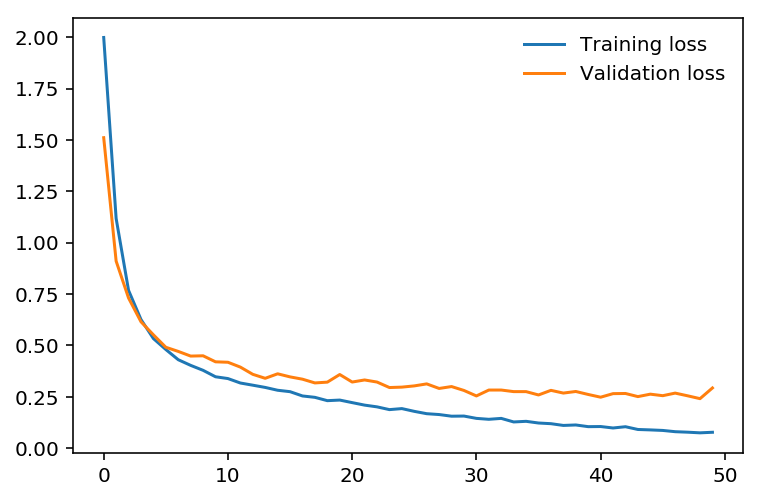

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [17]:
print("Accuracy obtained: {:.3f}%".format(accuracy/len(student_testloader)*100))

Accuracy obtained: 92.285%


In [18]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

From https://github.com/openmined/PySyft
 * branch              HEAD       -> FETCH_HEAD
Already up to date.
zip_safe flag not set; analyzing archive contents...
  Using cached https://files.pythonhosted.org/packages/0a/c6/96bbb3525a63ebc53ea700cc7d37ab9045542d33b4d262d0f0408ad9bbf2/lz4-2.1.10-cp36-cp36m-manylinux1_x86_64.whl
ERROR: syft 0.1.21a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.5.6 which is incompatible.
  Found existing installation: lz4 2.1.10
    Uninstalling lz4-2.1.10:
      Successfully uninstalled lz4-2.1.10
  Using cached https://files.pythonhosted.org/packages/f2/ca/5b5962361ed832847b6b2f9a2d0452c8c2f29a93baef850bb8ad067c7bf9/gevent-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/bf/45/142141aa47e01a5779f0fa5a53b81f8379ce8f2b1cd13df7d2f1d751ae42/greenlet-0.4.15-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: greenlet 0.4.15
    Uninstalling greenlet-0.4.15:
      Successfully uninstalled gr

In [19]:
from syft.frameworks.torch.differential_privacy import pate

W0703 10:04:37.434033 140586890868608 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0703 10:04:37.455140 140586890868608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [20]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=student_labels, noise_eps=epsilon, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps) 
print("Data Dependent Epsilon:", data_dep_eps) #Is the Epsilon value obtained by looking at how much teacher agree with each others

Data Independent Epsilon: 2261.51292546497
Data Dependent Epsilon: 105.92399312501276
